In [12]:
!pip install torchvision

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 86.7 MB/s eta 0:00:00


In [15]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from collections import deque

# Definir el tamaño de la imagen y la longitud de la secuencia
img_height, img_width = 64, 64  # Ajusta estos valores según lo que espera tu modelo
seq_length = 16  # Número de frames por secuencia

# Cargar el modelo de PyTorch
model = torch.load('violence_detection_model_state_dict.pth')
model.eval()

# Definir las transformaciones
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Inicializar el video
cap = cv2.VideoCapture("V_1.mp4")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Buffer para acumular frames y crear la secuencia
frame_buffer = deque(maxlen=seq_length)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break
    
    # Convertir el frame a RGB para Pillow
    pil_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Preprocesar el frame
    input_tensor = transform(pil_image)
    frame_buffer.append(input_tensor)

    # Procesar cuando el buffer tenga suficientes frames
    if len(frame_buffer) == seq_length:
        # Crear el tensor de entrada con la dimensión de secuencia temporal
        input_batch = torch.stack(list(frame_buffer)).unsqueeze(0).to(device)  # (1, seq_length, C, H, W)

        # Obtener predicción
        with torch.no_grad():
            output = model(input_batch)
            prediction = torch.sigmoid(output)
            prob = prediction.item()
        
        # Mostrar el resultado
        label = "Violence" if prob > 0.5 else "No Violence"
        color = (0, 0, 255) if label == "Violence" else (0, 255, 0)
        
        cv2.putText(frame, f"{label}: {prob:.2f}", 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    
    cv2.imshow('Violence Detection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

C:\Users\User\AppData\Local\Temp\ipykernel_11524\2730166127.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('violence_detection_model_state_dict.pth'

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

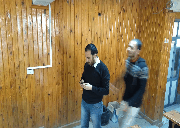

In [9]:
from PIL import Image
import cv2

# Ruta del video
video_path = "V_1.mp4"
cap = cv2.VideoCapture(video_path)

frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convertir a RGB para Pillow
    resized_frame = cv2.resize(frame, (180, 128))  # Redimensionar a 128x128
    frames.append(Image.fromarray(resized_frame))

cap.release()

# Guardar como GIF
gif_path = "output_video.gif"
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=100, loop=0)

# Mostrar el GIF en el notebook
from IPython.display import Image
Image(filename=gif_path)